#### After testing GNILC - We explore the results generated by GNILC

In [1]:
import os
import glob
import healpy as hp
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
import healpy as hp

In [2]:
# Load first ILC weights to see if they are zero
output = fits.getdata('../GNILC/output/reconstructed_maps_rec_block_masked_lband.fits')
prior = fits.getdata('../data/prior_21cm_gnilc.fits')
synch = fits.getdata('../Synch/DGSE_n-2_nc-252_ns-256_bw-mwa-32float_syncmod-1.fits')
synch = synch * 1000                                                                            # to mK
input = fits.getdata('../data/total_map_gnilc.fits')

print("Recovered output min/max/mean:", np.min(output), np.max(output), np.mean(output))
print("Prior 21 cm min/max/mean:", np.min(prior), np.max(prior), np.mean(prior))
print("synchrotron min/max/mean in mK:", np.min(synch), np.max(synch), np.mean(synch))
print("input min/max/mean in mK:", np.min(input), np.max(input), np.mean(input))

Recovered output min/max/mean: -19.708071070103852 25.181321375436962 -3.511700478929571e-05
Prior 21 cm min/max/mean: -1.0263569 0.9838108 7.0551565e-08
synchrotron min/max/mean in mK: 175.9276 126551.25 1772.0631
input min/max/mean in mK: 175.89703 126551.09 1773.6035


In [3]:
hdul = fits.open('../Synch/DGSE_n-2_nc-252_ns-256_bw-mwa-32float_syncmod-1.fits')

hdul.info()
print(hdul[0].header)

Filename: ../Synch/DGSE_n-2_nc-252_ns-256_bw-mwa-32float_syncmod-1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   (786432, 252)   float32   
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =               786432                                                  NAXIS2  =                  252                                                  EXTEND  =                    T                                                  ORIGIN  = 'Converted from .npy'                                                 FILENAME= 'DGSE_n-2_nc-252_ns-256_bw-mwa-32float_syncmod-1.npy'                 END                                                                                                                                                          

In [4]:
print(f'reconstructed {output.shape}')

reconstructed (5, 786432)


In [5]:
# info
n_chan, n_pix = output.shape
nside = hp.npix2nside(n_pix)

print(f'The Nside of the reconstructed map {nside}')

The Nside of the reconstructed map 256


Frequency array (5 channels): [ 580.    688.75  797.5   906.25 1015.  ]
Computed bin width: 87.00 MHz
Binned cube shape: (4, 786432)
Binned frequencies (MHz): [580.   688.75 797.5  906.25]


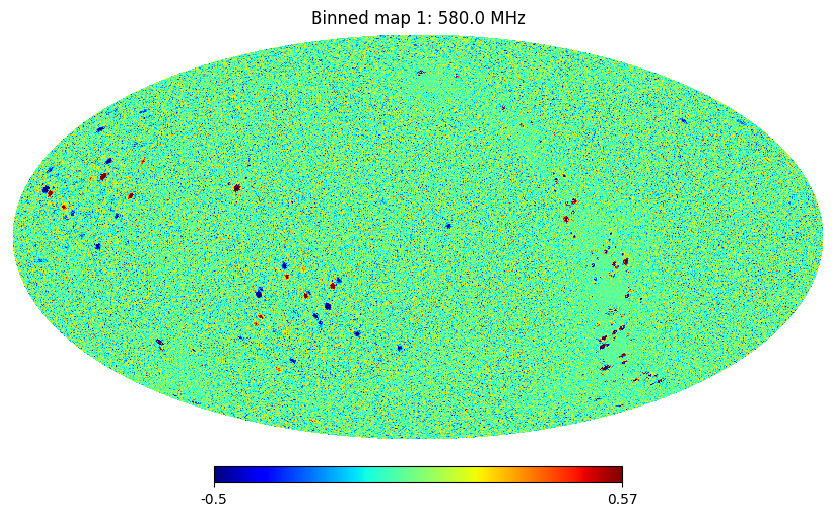

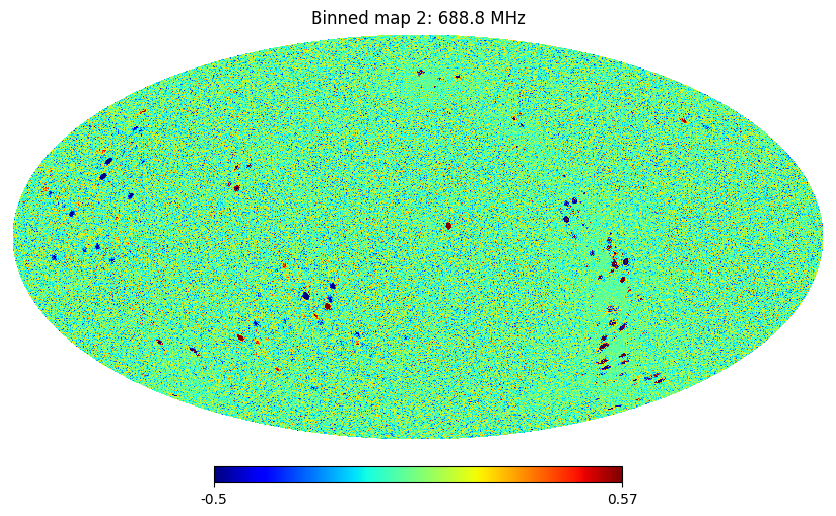

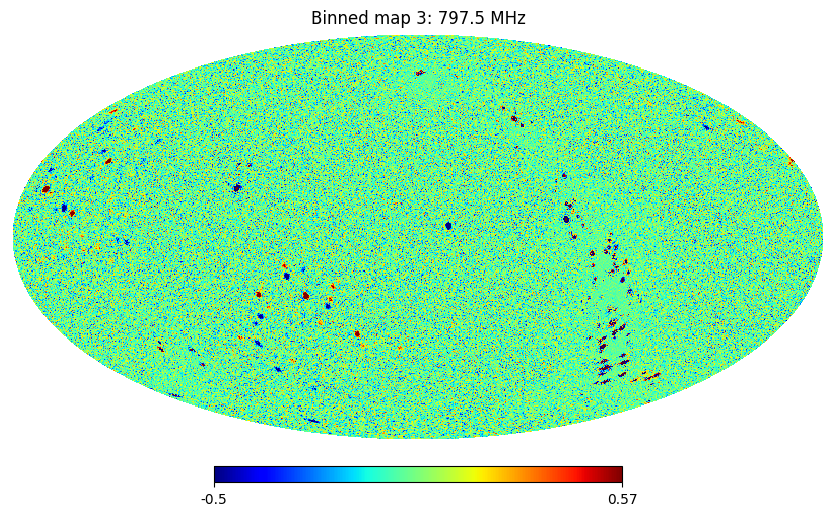

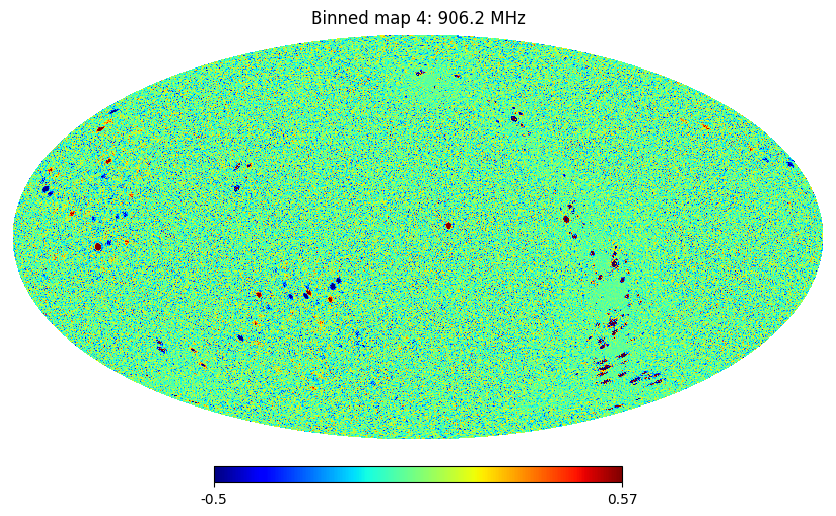

In [8]:
# freqs
freq_min = 580      # MHz
freq_max = 1015     
nchannels = output.shape[0]  
n_bins = 5       
nside = 256


# FREQUENCY SETUP
freq = np.linspace(freq_min, freq_max, nchannels)
print(f"Frequency array ({len(freq)} channels): {freq}")

# Automatically compute bin width
bin_width = (freq_max - freq_min) / n_bins
print(f"Computed bin width: {bin_width:.2f} MHz")

# Define bin edges
bins = np.arange(freq_min, freq_max + bin_width, bin_width)


# BINNING PROCESS
binned_maps = []
binned_freqs = []

for i in range(len(bins) - 1):
    fmin, fmax = bins[i], bins[i+1]
    mask = (freq >= fmin) & (freq < fmax)

    if np.any(mask): 

        # Average the maps across this frequency bin
        binned_map = np.mean(output[mask], axis=0)
        binned_maps.append(binned_map)
        binned_freqs.append(np.mean(freq[mask]))

binned_maps = np.array(binned_maps)
binned_freqs = np.array(binned_freqs)

print("Binned cube shape:", binned_maps.shape)
print("Binned frequencies (MHz):", binned_freqs)


# PLOTTING
for i, (m, f) in enumerate(zip(binned_maps, binned_freqs)):
    hp.mollview(m,
                title=f"Binned map {i+1}: {f:.1f} MHz",
                min=-0.5, max=0.57,
                cmap='jet')
    plt.show()


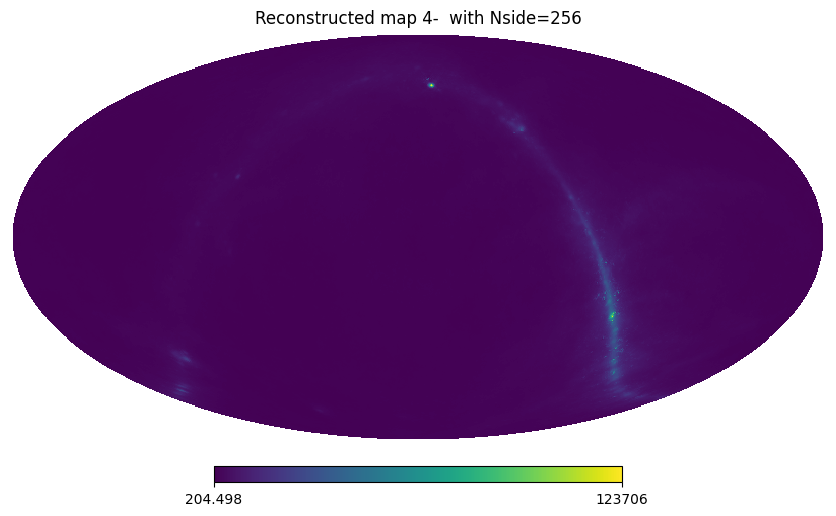

In [9]:
# view map
hp.mollview(synch[4], title=f"Reconstructed map {4}-  with Nside={nside}")
plt.show()

In [10]:
# Load 2D arrays directly
prior_all = fits.getdata("../data/prior_21cm_gnilc.fits")
input21_all = fits.getdata("../21 cm/map_n-2_nc-252_ns-256_bw-mwa-32float_nreal-1.fits")

# Pick one channel to compare (e.g. channel 4)
prior = prior_all[4]
input21 = input21_all[4]

def corr(a,b):
    m = np.isfinite(a) & np.isfinite(b)
    return np.corrcoef(a[m], b[m])[0,1]

print("prior shape:", prior.shape)
print("input21 shape:", input21.shape)
print("corr(prior, true21) =", corr(prior, input21))

prior shape: (786432,)
input21 shape: (786432,)
corr(prior, true21) = 0.4365158983335763


In [14]:
# Compute Cl
'''cl_rec = hp.anafast(output[4])


# Multipole array
ell = np.arange(len(cl_rec))

# Plot
plt.figure(figsize=(7,5))
plt.loglog(ell, cl_rec, label=f'GNILC {0}')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$ $(mK^2)$')
plt.title(f'Angular Power Spectrum Scale {1}')
plt.legend()
plt.show()'''

"cl_rec = hp.anafast(output[4])\n\n\n# Multipole array\nell = np.arange(len(cl_rec))\n\n# Plot\nplt.figure(figsize=(7,5))\nplt.loglog(ell, cl_rec, label=f'GNILC {0}')\nplt.xlabel(r'$\\ell$')\nplt.ylabel(r'$C_\\ell$ $(mK^2)$')\nplt.title(f'Angular Power Spectrum Scale {1}')\nplt.legend()\nplt.show()"

In [12]:
print(f'The actual HI have {prior.shape}')
print(f'Recovered have shape {output.shape}')

The actual HI have (786432,)
Recovered have shape (5, 786432)


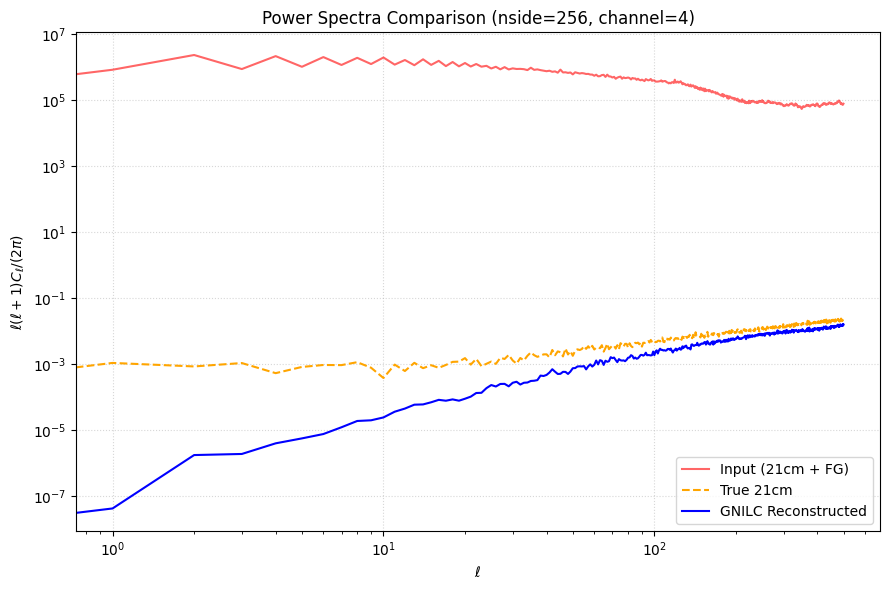

corr(reconstructed, prior)  = 0.628
corr(reconstructed, input)  = 0.002
corr(reconstructed, synch)  = 0.002


In [13]:
# File paths
rec_file   = '../GNILC/output/reconstructed_maps_rec_block_masked_lband.fits'  
prior_file = '../data/prior_21cm_gnilc.fits'                                
synch_file = '../Synch/DGSE_n-2_nc-252_ns-256_bw-mwa-32float_syncmod-1.fits'  
input_file = '../data/total_map_gnilc.fits'                                  


# Load maps
rec_map   = fits.getdata(rec_file)[4]    
prior_map = fits.getdata(prior_file)[4]
synch_map = fits.getdata(synch_file)[4]
input_map = fits.getdata(input_file)[4]

# Ensure consistent NSIDE
nside = hp.npix2nside(len(prior_map))

rec_map   = hp.ud_grade(rec_map,   nside)
prior_map = hp.ud_grade(prior_map, nside)
synch_map = hp.ud_grade(synch_map, nside)
input_map = hp.ud_grade(input_map, nside)


# Remove monopole (mean)

rec_map   -= np.mean(rec_map)
prior_map -= np.mean(prior_map)
synch_map -= np.mean(synch_map)
input_map -= np.mean(input_map)


# Compute Cl spectra
lmax = 3 * nside - 1

cl_rec   = hp.anafast(rec_map,   lmax=lmax)
cl_prior = hp.anafast(prior_map, lmax=lmax)
cl_synch = hp.anafast(synch_map, lmax=lmax)
cl_input = hp.anafast(input_map, lmax=lmax)

ell = np.arange(len(cl_rec))
Dl_rec   = ell * (ell + 1) * cl_rec   / (2 * np.pi)
Dl_prior = ell * (ell + 1) * cl_prior / (2 * np.pi)
Dl_synch = ell * (ell + 1) * cl_synch / (2 * np.pi)
Dl_input = ell * (ell + 1) * cl_input / (2 * np.pi)


# limit ell-range
ell_cut = 500
ell = ell[:ell_cut]
Dl_rec, Dl_prior, Dl_synch, Dl_input = (
    Dl_rec[:ell_cut],
    Dl_prior[:ell_cut],
    Dl_synch[:ell_cut],
    Dl_input[:ell_cut]
)


# Plot angular power spectra
plt.figure(figsize=(9,6))
plt.loglog(ell, Dl_input, label='Input (21cm + FG)', color='red', alpha=0.6)
#plt.loglog(ell, Dl_synch, label='Synchrotron', color='green', alpha=0.6)
plt.loglog(ell, Dl_prior, '--', label='True 21cm', color='orange')
plt.loglog(ell, Dl_rec, label='GNILC Reconstructed', color='blue')

plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell / (2\pi)$')
plt.title(f'Power Spectra Comparison (nside={nside}, channel=4)')
plt.legend()
plt.grid(True, ls=':', alpha=0.5)
plt.tight_layout()
plt.show()


#correlation coefficients

def corr(a, b):
    return np.corrcoef(a, b)[0,1]

print(f"corr(reconstructed, prior)  = {corr(rec_map, prior_map):.3f}")
print(f"corr(reconstructed, input)  = {corr(rec_map, input_map):.3f}")
print(f"corr(reconstructed, synch)  = {corr(rec_map, synch_map):.3f}")


Original frequencies (5): [ 580.    688.75  797.5   906.25 1015.  ]
Interpolated cube shape: (45, 786432)
Fine frequency array: [ 580.          589.88636364  599.77272727  609.65909091  619.54545455
  629.43181818  639.31818182  649.20454545  659.09090909  668.97727273
  678.86363636  688.75        698.63636364  708.52272727  718.40909091
  728.29545455  738.18181818  748.06818182  757.95454545  767.84090909
  777.72727273  787.61363636  797.5         807.38636364  817.27272727
  827.15909091  837.04545455  846.93181818  856.81818182  866.70454545
  876.59090909  886.47727273  896.36363636  906.25        916.13636364
  926.02272727  935.90909091  945.79545455  955.68181818  965.56818182
  975.45454545  985.34090909  995.22727273 1005.11363636 1015.        ]


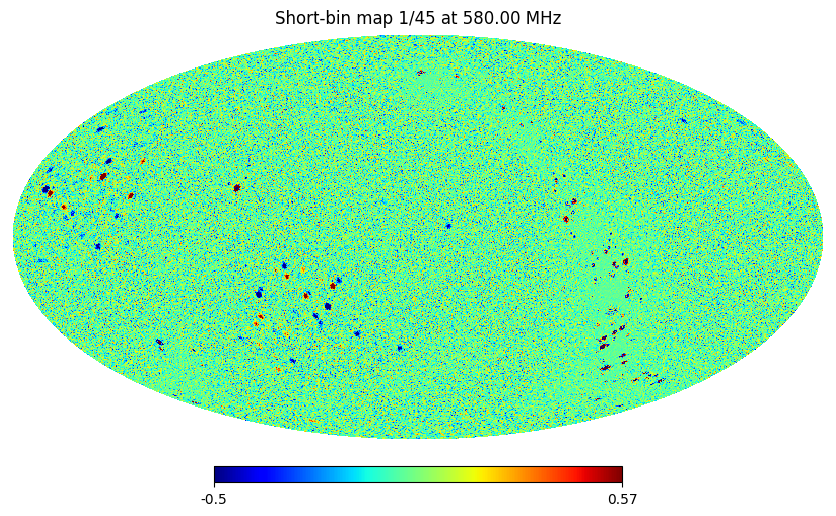

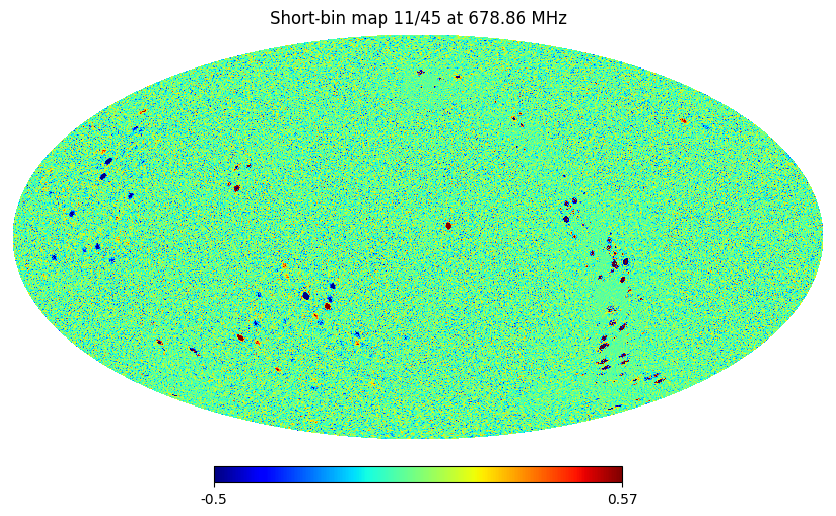

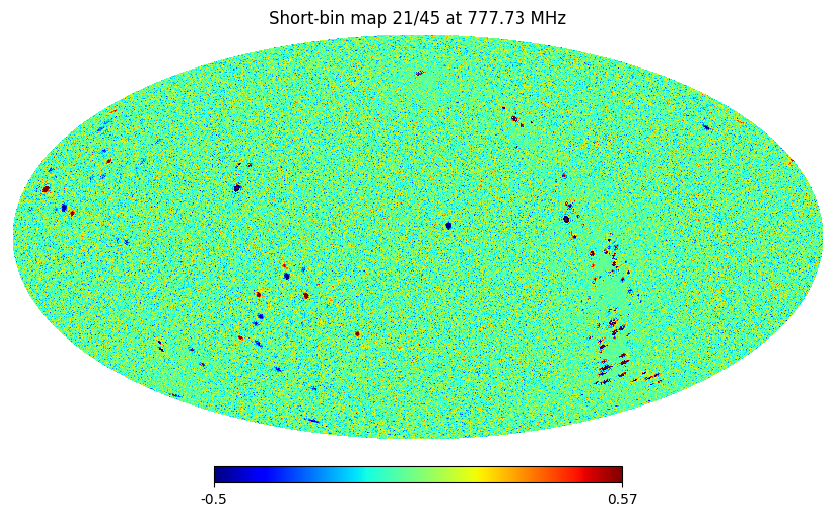

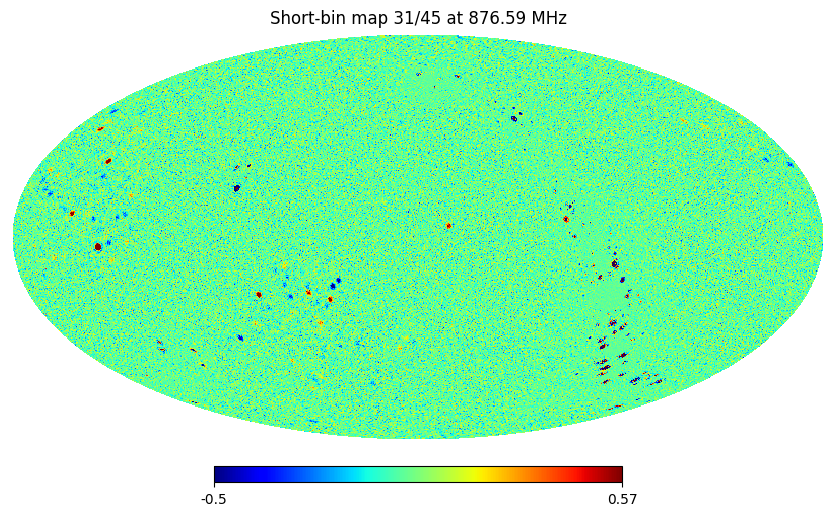

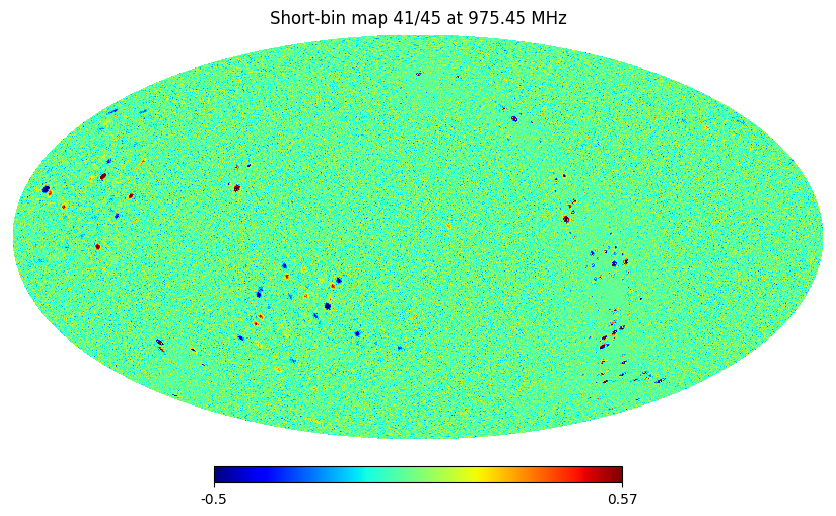

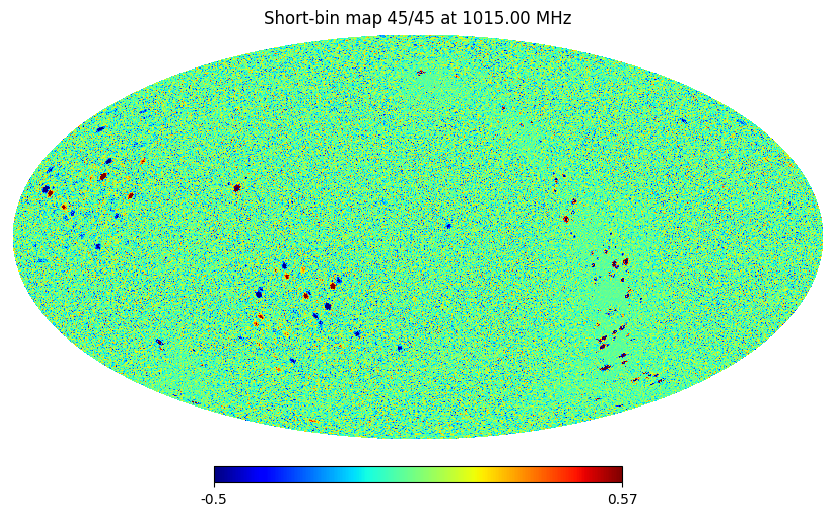